# SETTINGS

In [2]:
import os
import random
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error


In [1]:
TRAIN_DIR = "training_set"
TEST_DIR  = "test_set"
CSV_PATH  = "training_set_pixel_size_and_HC.csv"
IMG_SIZE  = 64


In [3]:
df = pd.read_csv(CSV_PATH)

train_files = os.listdir(TRAIN_DIR)
test_files  = os.listdir(TEST_DIR)


# DATA PREPARATION

In [4]:
train_image_files = [
    f for f in train_files if f.endswith("_HC.png")
]

train_image_files.sort()

csv_filenames = df["filename"].tolist()

missing_images = [
    f for f in csv_filenames if f not in train_image_files
]

extra_images = [
    f for f in train_image_files if f not in csv_filenames
]

train_image_names = []
train_hc_labels = []

for i in range(len(df)):
    fname = df["filename"].iloc[i]
    hc = df["head circumference (mm)"].iloc[i]
    if fname in train_image_files:
        train_image_names.append(fname)
        train_hc_labels.append(hc)

assert len(train_image_names) == len(train_hc_labels)


# EDA

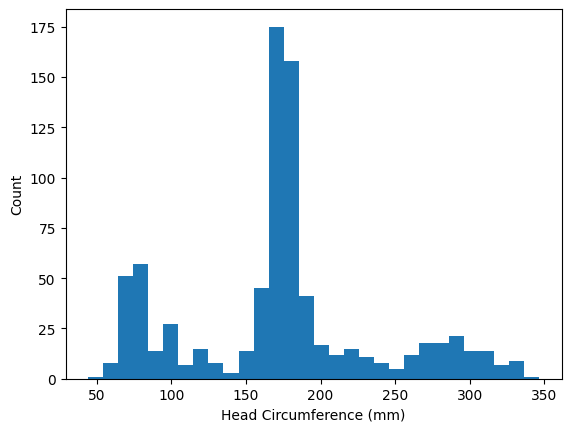

In [5]:
import matplotlib.pyplot as plt
import numpy as np

hc_values = np.array(train_hc_labels)

plt.hist(hc_values, bins=30)
plt.xlabel("Head Circumference (mm)")
plt.ylabel("Count")
plt.show()


In [6]:
from PIL import Image
import random

sample_indices = random.sample(range(len(train_image_names)), 300)

heights = []
widths = []
channels = []

for idx in sample_indices:
    img = Image.open(os.path.join(TRAIN_DIR, train_image_names[idx]))
    arr = np.array(img)

    if arr.ndim == 2:
        h, w = arr.shape
        c = 1
    else:
        h, w, c = arr.shape

    heights.append(h)
    widths.append(w)
    channels.append(c)

size_stats = {
    "height_min": min(heights),
    "height_max": max(heights),
    "width_min": min(widths),
    "width_max": max(widths),
    "channels": set(channels)
}

size_stats


{'height_min': 540,
 'height_max': 563,
 'width_min': 738,
 'width_max': 800,
 'channels': {1}}

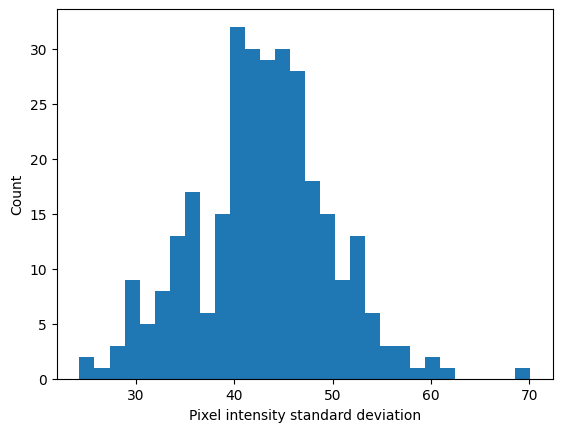

In [7]:
stds = []

for idx in sample_indices:
    img = Image.open(os.path.join(TRAIN_DIR, train_image_names[idx]))
    arr = np.array(img).astype(np.float32)
    stds.append(arr.std())

plt.hist(stds, bins=30)
plt.xlabel("Pixel intensity standard deviation")
plt.ylabel("Count")
plt.show()


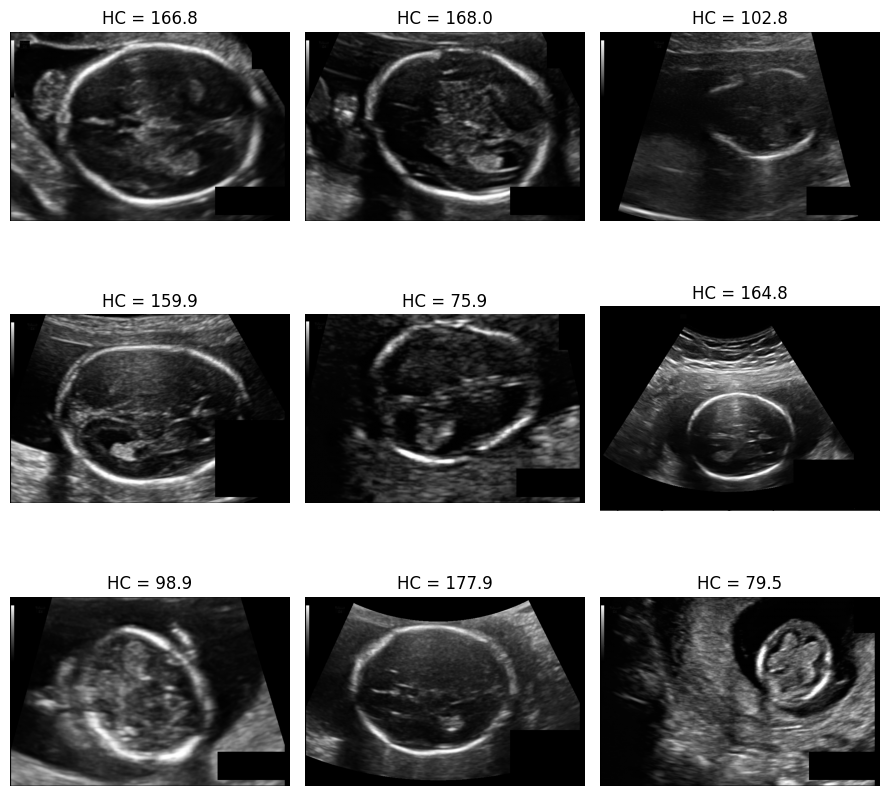

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for ax in axes.flat:
    idx = random.randint(0, len(train_image_names) - 1)
    img = Image.open(os.path.join(TRAIN_DIR, train_image_names[idx]))
    hc = train_hc_labels[idx]

    ax.imshow(img, cmap="gray")
    ax.set_title(f"HC = {hc:.1f}")
    ax.axis("off")

plt.tight_layout()
plt.show()


# Feature Extraction

In [5]:
def load_image_as_vector(path):
    img = Image.open(path).convert("L")
    img = img.resize((IMG_SIZE, IMG_SIZE))
    arr = np.array(img).astype(np.float32) / 255.0
    return arr.flatten()

X = np.stack([
    load_image_as_vector(os.path.join(TRAIN_DIR, fname))
    for fname in train_image_names
])

y = np.array(train_hc_labels)


# Random Forest Step

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [7]:
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)

mae


28.942735185185192

In [8]:
results = []

for n in [50, 100, 200]:
    for d in [None, 10, 20]:
        model = RandomForestRegressor(
            n_estimators=n,
            max_depth=d,
            random_state=42,
            n_jobs=-1
        )

        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, pred)

        results.append((n, d, mae))

results_df = pd.DataFrame(
    results,
    columns=["n_estimators", "max_depth", "MAE"]
)

results_df


,n_estimators,max_depth,MAE
0,50,NaN,29.051993
1,50,10.0,29.594309
2,50,20.0,28.952855
3,100,NaN,28.942735
4,100,10.0,29.117966
5,100,20.0,28.947758
6,200,NaN,28.748901
7,200,10.0,28.869979
8,200,20.0,28.893673
